This notebook consists of the evaluation of LLM-only model, fine-tuned model and our base RAG model.

In [ ]:
import pandas as pd


In [ ]:
data = pd.read_csv("final_eval_dataset.csv")

In [ ]:
data.head()

,Question,Ground_Truth,Source,Category,Context,llm_only_response,rag_response,fine_tuned_llm_response
0,What triggers Seasonal Affective Disorder (SAD)?,"SAD is triggered by seasonal changes, especial...",https://www.samhsa.gov/mental-health/seasonal-...,Mental Illness,"['Seasonal affective disorder, or SAD, is a co...",Seasonal Affective Disorder (SAD) is a type o...,"According to the given context, Seasonal Affec...",Seasonal affective disorder (SAD) is a type of...
1,What are the health risks of bulimia nervosa?,"Risks include dental decay, dehydration, and s...",https://www.samhsa.gov/mental-health/eating-di...,Mental Illness,['It is common that binge eating will lead to ...,Bulimia Nervosa (BN) is an eating disorder cha...,The health risks of bulimia nervosa include:\n...,Bulimia Nervosa (BN) is a serious eating disor...
2,How can someone with mental health problems ma...,By finding trustworthy individuals who provide...,https://www.samhsa.gov/mental-health/how-to-ta...,Mental Health,"[""Anyone can experience mental health problems...",Maintaining a support system is crucial for i...,"To maintain a support system, find someone who...",Here are some tips:\n1. Reach out to friends ...
3,What are the risk factors for schizophrenia?,Risk factors include genetic predisposition an...,https://www.samhsa.gov/mental-health/schizophr...,Mental Illness,['Schizophrenia is a serious brain disorder th...,Schizophrenia is a complex mental disorder tha...,"According to the context, there are no specifi...",Schizophrenia is a mental disorder that affect...
4,How does schizophrenia impact daily functioning?,"It affects work, socialization, and completing...",https://www.samhsa.gov/mental-health/schizophr...,Mental Illness,['Schizophrenia is a serious brain disorder th...,Schizophrenia is a chronic and severe mental ...,Schizophrenia can be extremely disruptive to a...,Schizophrenia is a mental disorder that affect...


In [ ]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
data = data.to_dict(orient='records')

In [ ]:
# Evaluation prompt
evaluation_prompt = """
### Task Description:
You are provided with an instruction (or query), a response to evaluate, a reference answer that represents an ideal response, and evaluation criteria. Additionally, you are given responses from three models: an LLM-only response, a RAG response, and a fine-tuned LLM response. Your task is to evaluate and compare the three responses with the reference answer based on the provided criteria.

1. Assess the quality of all three responses strictly based on the given rubric and criteria (relevance, semantic similarity, accuracy, factual correctness, completeness, clarity, and conciseness), not general impressions.
2. Write short feedback for each response based on the rubric, highlighting strengths and weaknesses for each criterion.
3. Provide feedback in the specified format.
4. Finally, assign an overall score out of 10 for LLM-only response, RAG response and the fine-tuned LLM response respectively.


### The instruction to evaluate:
{Question}

### LLM Only Response:
{llm_only_response}

### RAG Response:
{rag_response}

### Fine-Tuned LLM Response:
{fine_tuned_llm_response}

### Reference Answer:
{Ground_Truth}

### Rubric for Individual Criteria:
- **Relevance**: How effectively does the response address the specific requirements or intent of the query?
- **Semantic Similarity**: To what extent does the response capture the meaning or intent of the reference answer, even if the phrasing differs?
- **Accuracy**: Does the response provide correct and logically sound information in relation to the query?
- **Factual Correctness**: Are the facts presented in the response verified and consistent with reliable sources or the reference answer?
- **Completeness**: Does the response thoroughly cover all essential aspects of the query without omitting critical information?
- **Clarity**: Is the response expressed in a manner that is straightforward, unambiguous, and easy to comprehend?
- **Conciseness**: Does the response convey the necessary information succinctly, avoiding extraneous details or redundancy?

### Output Format:
Feedback:
- LLM Only Response:
    - Relevance: {{feedback}}
    - Semantic Similarity: {{feedback}}
    - Accuracy: {{feedback}} [RESULT]
    - Factual Correctness: {{feedback}}
    - Completeness: {{feedback}}
    - Clarity: {{feedback}}
    - Conciseness: {{feedback}}
- RAG Response:
    - Relevance: {{feedback}}
    - Semantic Similarity: {{feedback}}
    - Accuracy: {{feedback}}
    - Factual Correctness: {{feedback}}
    - Completeness: {{feedback}}
    - Clarity: {{feedback}}
    - Conciseness: {{feedback}}
- Fine-Tuned LLM Response:
    - Relevance: {{feedback}}
    - Semantic Similarity: {{feedback}}
    - Accuracy: {{feedback}}
    - Factual Correctness: {{feedback}}
    - Completeness: {{feedback}}
    - Clarity: {{feedback}}
    - Conciseness: {{feedback}}

### Overall Scores:
- LLM Only Overall Score: {{integer between 1 and 10}}
- RAG Overall Score: {{integer between 1 and 10}}
- Fine-Tuned LLM Overall Score: {{integer between 1 and 10}}
"""

In [ ]:
import openai

In [ ]:
!pip install openai

In [ ]:
!pip install httpx==0.27.2

In [ ]:
from openai import OpenAI

client = OpenAI(api_key = "YOUR_API_KEY") #Insert your api key here

In [ ]:
from tqdm import tqdm

In [ ]:
def evaluate_responses(instruction, llm_only_response, rag_response, fine_tuned_llm_response, reference_answer):
    prompt = evaluation_prompt.format(
        Question=instruction,
        llm_only_response=llm_only_response,
        rag_response=rag_response,
        fine_tuned_llm_response = fine_tuned_llm_response,
        Ground_Truth=reference_answer
    )

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a helpful assistant evaluating model responses."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=1000,
        temperature=0.5
    )

    s = response.choices[0].message.content
    print("Evaluation Output:")
    print(s)

    llm_only_score = re.search(r'LLM Only Overall Score: (\d+)', s).group(1).strip()
    rag_score = re.search(r'RAG Overall Score: (\d+)', s).group(1).strip()
    fine_tuned_score = re.search(r'Fine-Tuned LLM Overall Score: (\d+)', s).group(1).strip()

    return int(llm_only_score), int(rag_score), int(fine_tuned_score)

evaluations = []
for data in tqdm(data, desc="Evaluating responses", unit="sample"):
    instruction = data["Question"]
    llm_only_response = data["llm_only_response"]
    rag_response = data["rag_response"]
    fine_tuned_llm_response = data["fine_tuned_llm_response"]
    reference_answer = data["Ground_Truth"]

    llm_only_score, rag_score, fine_tuned_score = evaluate_responses(
        instruction, llm_only_response, rag_response, fine_tuned_llm_response, reference_answer
    )

    evaluations.append({
        "Question": instruction,
        "Ground_Truth": reference_answer,
        "llm_only_response": llm_only_response,
        "rag_response": rag_response,
        "fine_tuned_llm_response": fine_tuned_llm_response,
        "LLM_Only_Score": llm_only_score,
        "RAG_Score": rag_score,
        "Fine_Tuned_Score": fine_tuned_score
    })

Evaluating responses:   1%|          | 1/100 [00:04<08:05,  4.91s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the query about triggers for SAD. 
    - Semantic Similarity: The response captures the essence of the reference answer but includes additional details that are not present in the reference.
    - Accuracy: The information provided is generally accurate, though it could be misleading by suggesting that the causes are not fully understood when the reference focuses on seasonal changes.
    - Factual Correctness: The facts presented are correct, but the discussion on melatonin, while relevant, is not necessary for the query.
    - Completeness: The response provides some additional context about SAD but does not fully align with the simplicity of the reference answer.
    - Clarity: The response is clear, but the additional details may detract from the main point.
    - Conciseness: The response could be more concise; it includes unnecessary information that could be omitted.

- RA

Evaluating responses:   2%|▏         | 2/100 [00:09<07:31,  4.61s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response addresses the query about health risks associated with bulimia nervosa but lacks specific details about those risks. 
    - Semantic Similarity: The response captures the essence of the reference answer but does not provide the same level of specificity. 
    - Accuracy: The description of bulimia nervosa is accurate, but it lacks the necessary detail about health risks. [RESULT]
    - Factual Correctness: The information presented is factually correct regarding bulimia nervosa but does not mention specific health risks. 
    - Completeness: The response is incomplete as it does not enumerate the health risks associated with bulimia nervosa.
    - Clarity: The response is clear but could be more informative.
    - Conciseness: The response is concise but at the expense of necessary detail.

- RAG Response:
    - Relevance: The response is highly relevant as it directly lists the health risks associated with

Evaluating responses:   3%|▎         | 3/100 [00:14<08:10,  5.05s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses how to maintain a support system for individuals with mental health issues. 
    - Semantic Similarity: The response captures the essence of the reference answer, but lacks emphasis on trust and respect, key elements mentioned in the reference.
    - Accuracy: The information provided is generally accurate and aligns with common advice for maintaining a support system. 
    - Factual Correctness: The facts presented are consistent with general knowledge about support systems, but it could reference the importance of confidentiality more explicitly.
    - Completeness: The response is somewhat incomplete as it does not cover all essential aspects, such as the role of professional support or groups.
    - Clarity: The response is clear and easy to understand, with a logical flow.
    - Conciseness: The response is concise but could have included more information without becoming ov

Evaluating responses:   4%|▍         | 4/100 [00:20<08:18,  5.19s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the query about risk factors for schizophrenia, but it does not fully align with the specific focus of the reference answer. 
    - Semantic Similarity: The response captures some meaning related to risk factors but does not closely align with the concise nature of the reference answer. 
    - Accuracy: The information provided is generally accurate, mentioning genetic and environmental factors, but it lacks specificity regarding brain chemistry, which is a key aspect. [RESULT]
    - Factual Correctness: The facts presented are consistent with known information about schizophrenia; however, the mention of environmental toxins is less emphasized in the reference answer.
    - Completeness: The response covers some aspects of risk factors but omits critical elements like brain chemistry, making it less complete.
    - Clarity: The response is clear but could be more focused on the 

Evaluating responses:   5%|▌         | 5/100 [00:25<08:10,  5.16s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it discusses the impact of schizophrenia on daily functioning, but it could be more directly aligned with the specific aspects of daily life mentioned in the reference answer. 
    - Semantic Similarity: The response captures the general intent of the reference answer, but it does not directly reflect the simplicity and directness of the reference.
    - Accuracy: The information provided is accurate regarding the effects of schizophrenia on cognitive functions. [RESULT]
    - Factual Correctness: The facts presented are consistent with reliable sources on schizophrenia.
    - Completeness: The response is somewhat incomplete as it only mentions cognitive impairment and does not cover other areas of daily functioning, such as socialization or work.
    - Clarity: The response is clear and easy to understand, but the structure could be improved for better flow.
    - Conciseness: The response 

Evaluating responses:   6%|▌         | 6/100 [00:31<08:37,  5.51s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response addresses the query adequately by providing strategies for managing symptoms of social anxiety disorder. 
    - Semantic Similarity: The response captures the essence of the reference answer, though it does not directly mention therapy or medication, which are key components in the reference.
    - Accuracy: The strategies mentioned (relaxation techniques, challenging negative thoughts, building confidence) are accurate and relevant to managing social anxiety disorder. [RESULT]
    - Factual Correctness: The information presented is consistent with reliable sources regarding management techniques for social anxiety.
    - Completeness: While it covers several important strategies, it omits mention of medication and support groups, which are also critical for managing the disorder.
    - Clarity: The response is clear and easy to understand, with a logical structure.
    - Conciseness: The response is concis

Evaluating responses:   7%|▋         | 7/100 [00:37<08:30,  5.49s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it lists symptoms associated with anxiety disorders, addressing the query directly. 
    - Semantic Similarity: The response captures some of the symptoms mentioned in the reference answer but lacks direct mention of "excessive worry" and "difficulty concentrating." 
    - Accuracy: The symptoms listed are accurate and commonly associated with anxiety disorders. [RESULT]
    - Factual Correctness: All information presented is factually correct and aligns with known symptoms of anxiety disorders.
    - Completeness: The response is somewhat complete but misses key symptoms like "excessive worry" and "difficulty concentrating" that are in the reference answer.
    - Clarity: The response is clear and easy to read, with a well-structured list format.
    - Conciseness: The response is somewhat lengthy but generally concise in presenting the symptoms without unnecessary detail.

- RAG Response:
 

Evaluating responses:   8%|▊         | 8/100 [00:42<08:10,  5.33s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response addresses the query about mental health's impact on decision-making but lacks depth and specific examples. 
    - Semantic Similarity: It captures the overall idea of mental health affecting decision-making but does not align closely with the reference answer's phrasing. 
    - Accuracy: The information provided is generally accurate but oversimplified. [RESULT]
    - Factual Correctness: The response is factually correct but lacks detailed support for its claims. 
    - Completeness: It does not cover essential aspects such as how mental health can lead to specific decision-making issues.
    - Clarity: The response is clear but could be more informative. 
    - Conciseness: While the response is concise, it sacrifices depth for brevity. 

- RAG Response:
    - Relevance: This response effectively addresses how mental health impacts decision-making, providing a broader perspective. 
    - Semantic Similari

Evaluating responses:   9%|▉         | 9/100 [00:47<08:01,  5.29s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it directly addresses the query about ADHD. 
    - Semantic Similarity: It captures the essence of the reference answer but is more verbose and does not mention the age aspect.
    - Accuracy: The information provided is accurate regarding the symptoms of ADHD. [RESULT]
    - Factual Correctness: The facts presented are consistent with established knowledge about ADHD.
    - Completeness: While it covers the symptoms well, it lacks mention of the age aspect which is important for a full understanding.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is somewhat lengthy and could be more concise by omitting some details.

- RAG Response:
    - Relevance: The response addresses the query but lacks depth and specificity.
    - Semantic Similarity: It captures the general idea of ADHD but does not fully align with the reference answer's phrasing and foc

Evaluating responses:  10%|█         | 10/100 [00:53<08:09,  5.44s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it directly addresses the treatment options for SAD.
    - Semantic Similarity: The response captures the intent of the reference answer but misses some key elements like talk therapy and vitamin D supplements.
    - Accuracy: The information provided is accurate regarding treatment options for SAD. [RESULT]
    - Factual Correctness: The treatments mentioned (light therapy, medications) are correct and commonly accepted.
    - Completeness: The response lacks mention of talk therapy and vitamin D supplements, which are part of effective treatment.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is concise but could include more information without being verbose.

- RAG Response:
    - Relevance: The response is relevant as it discusses effective treatments for SAD.
    - Semantic Similarity: It captures the overall intent of the reference answer b

Evaluating responses:  11%|█         | 11/100 [00:58<07:56,  5.35s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the importance of mental health throughout life. 
    - Semantic Similarity: The response captures the essence of the reference answer but does not fully align with its brevity and focus on well-being.
    - Accuracy: The information provided is generally accurate regarding the link between mental and physical health and the impact on relationships. [RESULT]
    - Factual Correctness: The facts presented are consistent with common knowledge about mental health.
    - Completeness: The response is somewhat incomplete as it does not cover the emotional, psychological, and social aspects of mental health.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is somewhat concise, but the list format could be streamlined for better focus.

- RAG Response:
    - Relevance: The response is relevant and directly addresses the importance of mental he

Evaluating responses:  12%|█▏        | 12/100 [01:02<07:36,  5.18s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response addresses the query about warning signs of suicide in youth but does not cover all critical indicators. 
    - Semantic Similarity: The response captures some of the intent of the reference answer, particularly regarding withdrawal and thoughts of self-harm.
    - Accuracy: The information presented is accurate but limited in scope. [RESULT]
    - Factual Correctness: The facts presented align with common knowledge about suicide warning signs.
    - Completeness: The response is incomplete as it omits several significant warning signs mentioned in the reference answer.
    - Clarity: The response is clear and straightforward, making it easy to understand.
    - Conciseness: The response is concise but could include more information without becoming verbose.

- RAG Response:
    - Relevance: The response is relevant and directly addresses the query with a comprehensive list of warning signs.
    - Semantic S

Evaluating responses:  13%|█▎        | 13/100 [01:07<07:08,  4.93s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the topic of self-harm and its emotional context. 
    - Semantic Similarity: It captures the essence of the reference answer regarding emotional pain but lacks specific mention of relief from loneliness or anger.
    - Accuracy: The information provided is accurate regarding the emotional aspects of self-harm. 
    - Factual Correctness: The response is factually correct in describing self-harm as a coping mechanism.
    - Completeness: The response lacks depth and does not cover the range of reasons for self-harm, missing critical aspects mentioned in the reference.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is concise but sacrifices completeness for brevity.

- RAG Response:
    - Relevance: The response is highly relevant, effectively addressing the reasons behind self-harm.
    - Semantic Similarity: It closely aligns with th

Evaluating responses:  14%|█▍        | 14/100 [01:11<06:48,  4.75s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the role of communication in preventing suicide directly.
    - Semantic Similarity: The response captures the essence of the reference answer but lacks the specific mention of stigma.
    - Accuracy: The information provided is accurate and logically sound regarding the importance of communication in suicide prevention. [RESULT]
    - Factual Correctness: The facts presented are consistent with general understanding and reliable sources on suicide prevention.
    - Completeness: The response covers important aspects but omits some details about the broader impact of communication, such as stigma reduction.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is concise but could be more succinct in some parts.

- RAG Response:
    - Relevance: The response is highly relevant and directly answers the query about the role of communication in

Evaluating responses:  15%|█▌        | 15/100 [01:16<06:56,  4.90s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it discusses therapy in the context of self-harm, addressing the query effectively. 
    - Semantic Similarity: The response captures the main idea of the reference answer but lacks the specific mention of healthier coping mechanisms. 
    - Accuracy: The information provided about self-harm and therapy is accurate and aligned with common understandings of the topic. [RESULT]
    - Factual Correctness: The response presents correct information regarding self-harm and the role of therapy. 
    - Completeness: It is somewhat complete but could benefit from more detail on how therapy specifically helps in addressing self-harm. 
    - Clarity: The response is clear and easy to understand, with straightforward language. 
    - Conciseness: The response is concise, delivering the necessary information without unnecessary elaboration. 

- RAG Response:
    - Relevance: The response is relevant as it

Evaluating responses:  16%|█▌        | 16/100 [01:21<06:46,  4.84s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses emotional triggers linked to self-harm. However, it could be more focused on the specific triggers mentioned in the reference answer. 
    - Semantic Similarity: The response captures the essence of the emotional triggers but does not explicitly mention loneliness, which is a key trigger in the reference answer.
    - Accuracy: The information provided is accurate regarding emotional triggers associated with self-harm. [RESULT]
    - Factual Correctness: The response is factually correct, discussing common emotional triggers.
    - Completeness: The response includes some triggers but lacks completeness, as it does not cover loneliness and other potential triggers mentioned in the reference answer.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is concise but could be more direct in addressing the specific triggers mentioned in the re

Evaluating responses:  17%|█▋        | 17/100 [01:28<07:29,  5.42s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response addresses the query but focuses more on warning signs rather than direct intervention methods. It partially meets the requirements. 
    - Semantic Similarity: There is limited semantic similarity with the reference answer, as it does not capture the essence of directly asking about suicidal thoughts. 
    - Accuracy: The information provided about warning signs is accurate but does not fully answer the query regarding intervention. [RESULT]
    - Factual Correctness: The warning signs mentioned are factually correct and relevant to the topic.
    - Completeness: The response lacks critical information on how to intervene, such as asking direct questions or connecting to help, resulting in incomplete guidance.
    - Clarity: The response is clear in its presentation of warning signs but lacks clarity on intervention strategies.
    - Conciseness: The response is concise but omits essential details about int

Evaluating responses:  18%|█▊        | 18/100 [01:33<07:29,  5.49s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses challenges faced by individuals with schizophrenia, but it does not fully encompass the socialization and employment aspects mentioned in the reference answer.
    - Semantic Similarity: There is some semantic similarity, as it discusses hallucinations and delusions, but it lacks mention of socialization and daily routines, which are critical components of the reference answer.
    - Accuracy: The information provided is generally accurate regarding the challenges of schizophrenia, but it misses key aspects related to social and occupational functioning. [RESULT]
    - Factual Correctness: The facts presented are correct, but the omission of specific challenges related to socialization and employment affects the overall assessment.
    - Completeness: The response is incomplete as it does not cover all essential aspects of the challenges faced, particularly social and occupationa

Evaluating responses:  19%|█▉        | 19/100 [01:39<07:30,  5.56s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response partially addresses the query but lacks specific details that distinguish bulimia nervosa from binge eating disorder. 
    - Semantic Similarity: The response captures the general idea of both disorders but does not effectively convey the differences as emphasized in the reference answer. 
    - Accuracy: The information is generally accurate but is too vague to provide a clear understanding of the differences. [RESULT]
    - Factual Correctness: The response is factually correct in stating both disorders involve excessive food intake, but it fails to mention purging behaviors specific to bulimia.
    - Completeness: The response is incomplete as it does not outline the key differences between the two disorders.
    - Clarity: The response is clear but lacks depth, making it less informative.
    - Conciseness: The response is concise but at the expense of essential details.

- RAG Response:
    - Relevance

Evaluating responses:  20%|██        | 20/100 [01:44<06:58,  5.23s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the physical symptoms linked to panic disorder, but it lacks detail. 
    - Semantic Similarity: It captures the general meaning of the reference answer but misses some key symptoms. 
    - Accuracy: The information provided is accurate but incomplete. [RESULT]
    - Factual Correctness: The symptoms mentioned are correct, but it does not include all relevant symptoms mentioned in the reference answer. 
    - Completeness: The response is incomplete, listing only two symptoms when more are typically associated with panic disorder. 
    - Clarity: The response is clear and easy to understand. 
    - Conciseness: The response is concise but at the cost of completeness. 

- RAG Response:
    - Relevance: The response is highly relevant as it lists multiple physical symptoms associated with panic disorder. 
    - Semantic Similarity: It captures the essence of the reference answer, i

Evaluating responses:  21%|██        | 21/100 [01:49<06:44,  5.11s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response addresses the query but lacks a direct explanation of why panic attacks are frightening, focusing instead on general characteristics. 
    - Semantic Similarity: The response captures some elements of the reference answer but does not align closely with its specific wording or intent.
    - Accuracy: The information provided is generally accurate but not entirely focused on the frightening aspect of panic attacks. [RESULT]
    - Factual Correctness: The response correctly identifies panic attacks as intense fear but does not mention specific symptoms that contribute to the fear.
    - Completeness: The response is somewhat complete in describing panic attacks but omits critical details about the frightening symptoms.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is concise but could be more focused on the specific question.

- RAG Response:
    - Relevance: Thi

Evaluating responses:  22%|██▏       | 22/100 [01:53<06:31,  5.02s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response effectively addresses the query by discussing various populations that the Zero Suicide framework targets. 
    - Semantic Similarity: The response captures the intent of the reference answer by indicating a broad target audience, though it lacks the specific mention of healthcare systems.
    - Accuracy: The information provided is accurate regarding the populations that may benefit from the framework. [RESULT]
    - Factual Correctness: The details about individuals experiencing suicidal thoughts, trauma, and mental health struggles align with known facts about suicide prevention efforts.
    - Completeness: The response is fairly complete, covering multiple populations but could mention the overarching focus on healthcare systems.
    - Clarity: The response is clear and easy to understand, with well-structured sentences.
    - Conciseness: While the response is somewhat detailed, it could be more concis

Evaluating responses:  23%|██▎       | 23/100 [01:58<06:23,  4.97s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response addresses the query by linking insomnia, depression, and feelings of worthlessness, but it could be more direct in connecting these concepts. 
    - Semantic Similarity: The response captures some of the intent of the reference answer but lacks the specific connection to racing thoughts mentioned in the reference. 
    - Accuracy: The information regarding the links between insomnia and depression is generally accurate. [RESULT]
    - Factual Correctness: The response correctly identifies insomnia as a symptom of depression but does not provide specific statistics or details. 
    - Completeness: The response lacks depth; it does not fully explore how insomnia exacerbates feelings of worthlessness. 
    - Clarity: The response is clear but could be more concise. 
    - Conciseness: The response is somewhat concise but could benefit from tighter phrasing. 

- RAG Response:
    - Relevance: The response is so

Evaluating responses:  24%|██▍       | 24/100 [02:03<06:18,  4.99s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response addresses the query about recognizing suicide warning signs but lacks a direct focus on the specific signs. It provides general information about suicide without fully answering the question. 
    - Semantic Similarity: There is some overlap in the meaning but not much direct similarity to the reference answer, which lists specific behaviors. 
    - Accuracy: The information is generally accurate but lacks specificity regarding the warning signs. [RESULT]
    - Factual Correctness: The facts presented are correct but do not fully align with the specifics of the reference answer.
    - Completeness: The response does not cover enough warning signs to be considered complete, omitting many critical indicators.
    - Clarity: The response is clear in its language but could be more focused on the specific request.
    - Conciseness: While the response is relatively concise, it could be more so by eliminating gen

Evaluating responses:  25%|██▌       | 25/100 [02:07<05:57,  4.76s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it lists physical symptoms of bulimia nervosa.
    - Semantic Similarity: It captures some aspects of the reference answer but does not fully align with its brevity.
    - Accuracy: The information provided is accurate regarding the symptoms associated with bulimia nervosa. [RESULT]
    - Factual Correctness: The facts presented are consistent with known symptoms of bulimia nervosa.
    - Completeness: The response provides a good number of symptoms but misses some critical ones like severe dehydration.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is somewhat concise but could be more so by eliminating less critical details.
- RAG Response:
    - Relevance: The response is relevant as it lists physical symptoms associated with bulimia nervosa.
    - Semantic Similarity: It captures similar meanings to the reference answer but lacks direct alignm

Evaluating responses:  26%|██▌       | 26/100 [02:12<05:54,  4.79s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses resources for concerned parents, but it lacks specific mention of critical resources like healthcare providers and crisis helplines.
    - Semantic Similarity: The response captures the general intent of the reference answer but does not align closely in terms of specific resources mentioned.
    - Accuracy: The information provided is accurate regarding the types of resources available, but it misses some key options.
    - Factual Correctness: The facts presented are correct, but the omission of certain resources (like crisis helplines) reduces its effectiveness.
    - Completeness: The response is incomplete as it does not cover all essential resources mentioned in the reference answer.
    - Clarity: The response is clear and easy to understand, with a straightforward structure.
    - Conciseness: The response is concise, presenting the information without unnecessary details

Evaluating responses:  27%|██▋       | 27/100 [02:17<05:51,  4.81s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response directly addresses the query by discussing Generalized Anxiety Disorder and its symptoms. However, it could be more focused on listing the symptoms explicitly. 
    - Semantic Similarity: The response captures the essence of the reference answer but does not align closely in terms of specific symptoms listed. 
    - Accuracy: The information about GAD is accurate, but the symptoms are not fully detailed. [RESULT]
    - Factual Correctness: The facts presented are consistent with reliable sources regarding GAD.
    - Completeness: The response lacks a comprehensive list of symptoms, omitting critical information that would provide a fuller understanding.
    - Clarity: The response is mostly clear but could be more concise in conveying the symptoms.
    - Conciseness: The response includes some extraneous details that could be omitted for a more succinct answer.

- RAG Response:
    - Relevance: This respons

Evaluating responses:  28%|██▊       | 28/100 [02:22<05:43,  4.77s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it discusses treatment options for schizophrenia, but it could be more comprehensive. 
    - Semantic Similarity: It captures some of the intent of the reference answer but misses key elements like family support and adherence to treatment. 
    - Accuracy: The information provided is accurate regarding medications used in treatment. [RESULT]
    - Factual Correctness: The medications listed are correct and commonly used for schizophrenia.
    - Completeness: The response lacks mention of therapy types and support systems, making it incomplete.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The information is conveyed succinctly, but it could include more details without being overly verbose.

- RAG Response:
    - Relevance: The response is highly relevant and covers the treatment of schizophrenia effectively.
    - Semantic Similarity: It aligns well with th

Evaluating responses:  29%|██▉       | 29/100 [02:27<05:40,  4.80s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response effectively addresses the query by distinguishing between panic disorder and occasional panic attacks. 
    - Semantic Similarity: The meaning aligns well with the reference answer, although some phrases differ. 
    - Accuracy: The information is mostly accurate, but it could clarify that panic disorder involves persistent worry about future attacks. [RESULT]
    - Factual Correctness: The facts presented are generally correct, but the description of panic attacks could be more precise regarding their duration and characteristics.
    - Completeness: The response includes key aspects of both conditions, but it lacks detail on the triggers of occasional panic attacks.
    - Clarity: The response is clear and understandable, though some sentences could be simplified.
    - Conciseness: The response is fairly concise but could omit repetitive phrases for greater succinctness.

- RAG Response:
    - Relevance:

Evaluating responses:  30%|███       | 30/100 [02:31<05:33,  4.76s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses psychotherapy's role in treating eating disorders. 
    - Semantic Similarity: It captures the essence of the reference answer but lacks some specific details. 
    - Accuracy: The information provided is generally accurate regarding the purpose of psychotherapy. [RESULT]
    - Factual Correctness: The response correctly states that psychotherapy helps in understanding symptoms and developing coping skills.
    - Completeness: The response is somewhat incomplete as it does not mention specific therapeutic approaches or strategies. 
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is concise but could benefit from a bit more detail without becoming verbose.

- RAG Response:
    - Relevance: The response is highly relevant and directly addresses the role of psychotherapy in recovery from eating disorders.
    - Semantic Similarity: It ali

Evaluating responses:  31%|███       | 31/100 [02:37<05:39,  4.92s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the treatments for anxiety disorders directly.
    - Semantic Similarity: The response captures the intent of the reference answer but lacks some key elements like stress management techniques.
    - Accuracy: The information provided is accurate but incomplete regarding the range of treatments.
    - Factual Correctness: The mention of CBT and medications is factually correct, but it oversimplifies the topic.
    - Completeness: The response is incomplete as it omits several treatment options and does not address stress management.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is concise but may be too brief to cover the topic adequately.

- RAG Response:
    - Relevance: The response is highly relevant, addressing various treatments for anxiety disorders.
    - Semantic Similarity: It captures the intent of the reference answer wel

Evaluating responses:  32%|███▏      | 32/100 [02:42<05:33,  4.90s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response directly addresses the role of CBT in managing depression and self-esteem issues, making it relevant to the query.
    - Semantic Similarity: The response captures the essence of the reference answer by discussing the influence of thought patterns on emotions and behaviors.
    - Accuracy: The information presented is accurate regarding CBT's focus on negative thought patterns and behaviors.
    - Factual Correctness: The facts are consistent with established knowledge about CBT and its application in mental health.
    - Completeness: The response lacks depth in explaining how CBT specifically helps manage depression and self-esteem issues, missing critical components.
    - Clarity: The response is clear and easy to understand, effectively communicating the main points.
    - Conciseness: The response is concise but may benefit from additional details for completeness.

- RAG Response:
    - Relevance: Th

Evaluating responses:  33%|███▎      | 33/100 [02:46<05:28,  4.90s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response addresses the query about health risks associated with self-harm, providing relevant information. 
    - Semantic Similarity: The response captures some elements of the reference answer but does not fully align in terms of phrasing and completeness.
    - Accuracy: The information provided is generally accurate regarding the risks of self-harm. [RESULT]
    - Factual Correctness: The facts presented are correct and logically sound, aligning well with known health risks.
    - Completeness: The response is incomplete as it omits several critical health risks associated with self-harm, such as the risk of suicide.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is concise but could benefit from additional details about risks.

- RAG Response:
    - Relevance: The response effectively addresses the health risks of self-harm and is relevant to the query.
    - Semant

Evaluating responses:  34%|███▍      | 34/100 [02:52<05:32,  5.03s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the causes of social anxiety disorder. 
    - Semantic Similarity: The response captures the essence of the reference answer but lacks specific mention of learned behavior. 
    - Accuracy: The information provided is generally accurate, but it redundantly states the genetic component. [RESULT]
    - Factual Correctness: The response is factually correct regarding the general understanding of social anxiety disorder's causes.
    - Completeness: The response lacks completeness as it does not mention learned behavior or social trauma, which are part of the reference answer.
    - Clarity: The response is clear but could be better structured to avoid redundancy.
    - Conciseness: The response is somewhat concise but includes repetitive information about genetic factors.

- RAG Response:
    - Relevance: This response is relevant and directly addresses the causes of social anxiety 

Evaluating responses:  35%|███▌      | 35/100 [02:58<05:53,  5.45s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it directly addresses the query about the Four-Fold Breath technique.
    - Semantic Similarity: The response captures the essence of the Four-Fold Breath but does not mention its connection to yoga or relaxation explicitly, which is present in the reference answer.
    - Accuracy: The description of the technique is accurate, but the mention of Dr. Andrew Weil as the developer is misleading since the technique is rooted in ancient practices.
    - Factual Correctness: While the technique is described correctly, attributing it solely to Dr. Andrew Weil lacks factual correctness as it overlooks its historical origins.
    - Completeness: The response provides a good overview of the technique but lacks mention of its specific purpose related to relaxation and sleep, which is crucial.
    - Clarity: The explanation is clear and easy to understand.
    - Conciseness: The response is concise, pres

Evaluating responses:  36%|███▌      | 36/100 [03:04<06:00,  5.63s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it discusses family history as a risk factor for mental health conditions, but it does not directly answer how family history influences mental health. 
    - Semantic Similarity: The response captures some elements of the reference answer but fails to convey the simplicity of the relationship emphasized in the reference. 
    - Accuracy: The information provided about family history being a risk factor is accurate, but the mention of a systematic review is not directly relevant to the query. [RESULT]
    - Factual Correctness: The facts presented are generally correct, but the response implies a research context that may not be necessary for the question asked. 
    - Completeness: The response is incomplete as it does not fully explain the mechanisms by which family history influences mental health, which is a key aspect of the query. 
    - Clarity: The response is somewhat clear, but the 

Evaluating responses:  37%|███▋      | 37/100 [03:10<05:50,  5.56s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response effectively addresses the query by discussing how phobias impact daily life. 
    - Semantic Similarity: The response captures the general idea of daily life limitations due to phobias, but it does not closely match the phrasing of the reference answer.
    - Accuracy: The information provided is accurate regarding the effects of phobias on daily life. [RESULT]
    - Factual Correctness: The response is factually correct, as it describes appropriate consequences of phobias.
    - Completeness: The response is somewhat complete but could include additional aspects such as emotional impacts or specific examples.
    - Clarity: The response is clear and easy to understand, with a well-structured list.
    - Conciseness: The response is concise, though it could be slightly more succinct by reducing redundancy in wording.

- RAG Response:
    - Relevance: The response is relevant, addressing phobias and their im

Evaluating responses:  38%|███▊      | 38/100 [03:16<06:01,  5.83s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response addresses the query but does not explicitly mention the benefits of temperament therapy, which is the core of the question. 
    - Semantic Similarity: The response captures some intent of the reference answer regarding personal development but lacks the specific focus on self-acceptance and joy.
    - Accuracy: The information about NCCA's approach is somewhat accurate but may confuse NCCA with a different organization related to personality development. [RESULT]
    - Factual Correctness: The response incorrectly identifies NCCA as the National Center for Creative Arts rather than the National Center for Competency-Based Education, which affects its factual correctness.
    - Completeness: The response is lacking in depth regarding the specific benefits of temperament therapy, only briefly mentioning personality development.
    - Clarity: The response is clear but could be more straightforward in explici

Evaluating responses:  39%|███▉      | 39/100 [03:21<05:39,  5.56s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is somewhat relevant as it mentions the link between physical health and depression, but it does not directly answer how physical health affects feelings of depression. 
    - Semantic Similarity: The response captures some aspects of the reference answer's intent but lacks direct correlation to the physical health aspects mentioned in the reference.
    - Accuracy: The information presented is accurate, but it is too vague and lacks depth. [RESULT]
    - Factual Correctness: The response is factually correct in stating the relationship between physical health and depression.
    - Completeness: The response is incomplete as it does not elaborate on how physical health affects depression, missing critical information.
    - Clarity: The response is clear but does not provide substantial content to support its claims.
    - Conciseness: The response is concise but overly brief, lacking necessary detail.

- R

Evaluating responses:  40%|████      | 40/100 [03:26<05:17,  5.30s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the impact of lack of sunlight on SAD. 
    - Semantic Similarity: It captures the essence of the reference answer by discussing mood regulation but lacks some key points.
    - Accuracy: The information regarding serotonin and melatonin is accurate and relevant. [RESULT]
    - Factual Correctness: The response correctly identifies the role of sunlight in regulating mood-related chemicals.
    - Completeness: It lacks a mention of vitamin D and does not fully elaborate on how these changes affect mood and sleep.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is concise but could be more focused on key points regarding SAD.
  
- RAG Response:
    - Relevance: The response is relevant as it directly addresses the question about the effects of sunlight on SAD.
    - Semantic Similarity: It captures the main ideas but is less detailed tha

Evaluating responses:  41%|████      | 41/100 [03:32<05:38,  5.73s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response addresses the concern of social withdrawal in youth, but it could be more focused on why it is a concern rather than just listing effects. 
    - Semantic Similarity: The response does not capture the essence of the reference answer, which highlights feelings of hopelessness or distress specifically.
    - Accuracy: The information provided is generally accurate regarding the effects of social withdrawal but lacks depth.
    - Factual Correctness: The facts presented about academic performance and mental health risks are accurate but do not directly relate to the core concern mentioned in the reference answer. 
    - Completeness: The response is somewhat complete but lacks a broader context or a direct link to feelings of hopelessness, which is crucial to understanding the concern.
    - Clarity: The response is clear and easy to understand, with a logical structure.
    - Conciseness: The response is conc

Evaluating responses:  42%|████▏     | 42/100 [03:42<06:35,  6.82s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response addresses the query about ADHD treatment well, providing relevant information about behavioral therapy and medications. 
    - Semantic Similarity: The response captures the essential meaning of the reference answer but lacks mention of psychotherapy and education, which are also important aspects. 
    - Accuracy: The information provided about treatment methods is accurate and aligns with common practices in ADHD treatment. [RESULT]
    - Factual Correctness: The medications mentioned are factually correct and commonly used for ADHD treatment. 
    - Completeness: The response is somewhat incomplete as it does not mention education and behavior management strategies, which are part of the reference answer.
    - Clarity: The response is clear and easy to understand, with well-structured points. 
    - Conciseness: The response is concise, presenting the information without unnecessary elaboration. 

- RAG

Evaluating responses:  43%|████▎     | 43/100 [03:47<05:57,  6.27s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response effectively addresses the query by discussing the importance of early treatment for schizophrenia. 
    - Semantic Similarity: The response captures the essence of the reference answer but lacks the succinctness and directness of the reference. 
    - Accuracy: The information provided is accurate and logically sound regarding the benefits of early treatment. [RESULT]
    - Factual Correctness: The facts presented are consistent with reliable sources about schizophrenia treatment.
    - Completeness: The response covers key aspects but could include more about the long-term implications of untreated schizophrenia.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is somewhat verbose; it could be more concise without losing important information.

- RAG Response:
    - Relevance: The response is relevant as it directly addresses the importance of early treatment for

Evaluating responses:  44%|████▍     | 44/100 [03:52<05:33,  5.95s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response effectively addresses the query by identifying signs of binge eating disorder, but it could include more specific signs to enhance relevance. 
    - Semantic Similarity: The response captures the general intent of the reference answer but lacks some specific elements mentioned in the reference. 
    - Accuracy: The information provided is accurate regarding binge eating disorder. [RESULT]
    - Factual Correctness: The details regarding binge eating disorder are factually correct and aligned with established knowledge.
    - Completeness: The response is somewhat incomplete as it does not cover all the signs listed in the reference answer, such as using food as a coping mechanism.
    - Clarity: The response is clear and easy to understand, with a logical structure.
    - Conciseness: The response is concise, although it could benefit from additional details without becoming verbose.

- RAG Response:
    - 

Evaluating responses:  45%|████▌     | 45/100 [03:58<05:29,  5.98s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it discusses the impact of binge eating disorder on mental health, directly addressing the query. 
    - Semantic Similarity: The response captures the essence of the reference answer by mentioning feelings of guilt and low self-esteem, though it could have included more details.
    - Accuracy: The information provided is accurate regarding the effects of binge eating disorder on mental health. [RESULT]
    - Factual Correctness: The facts presented are consistent with known information about binge eating disorder and its mental health implications.
    - Completeness: The response is somewhat incomplete as it only briefly mentions low self-esteem without elaborating on other potential impacts, such as depression or anxiety.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is concise, but it could benefit from a bit more elaboration on the effects 

Evaluating responses:  46%|████▌     | 46/100 [04:05<05:41,  6.32s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response effectively addresses the query about the goal of the GLS Campus Program by outlining its focus on mental health awareness and support for students. 
    - Semantic Similarity: The meaning aligns well with the reference answer, though it does not explicitly mention reducing suicide risks, which is a key aspect of the reference.
    - Accuracy: The information provided is accurate regarding the program's goals. [RESULT]
    - Factual Correctness: The details about increasing awareness and reducing stigma are consistent with the program's objectives.
    - Completeness: The response covers several important aspects, but it lacks mention of suicide risk reduction, which is a critical part of the reference answer.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is concise, providing relevant information without unnecessary details.

- RAG Response:
    - Relevance: T

Evaluating responses:  47%|████▋     | 47/100 [04:17<07:08,  8.08s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response directly addresses the manifestation of OCD, making it relevant to the query.
    - Semantic Similarity: It captures the essence of the reference answer but lacks the succinctness and clarity of the reference.
    - Accuracy: The information provided about obsessions and compulsions is accurate. [RESULT]
    - Factual Correctness: The details given align well with established knowledge about OCD.
    - Completeness: The response is somewhat complete but could benefit from more examples or details.
    - Clarity: The response is generally clear, but the structure could be improved for better readability.
    - Conciseness: The response includes some unnecessary elaboration, which could be trimmed for brevity.

- RAG Response:
    - Relevance: The response is relevant, addressing the manifestations of OCD effectively.
    - Semantic Similarity: It captures the meaning of the reference answer but lacks a direc

Evaluating responses:  48%|████▊     | 48/100 [04:24<06:35,  7.60s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the query about resources for self-harm prevention, listing several appropriate options.
    - Semantic Similarity: The response does not closely align with the reference answer, which emphasizes specialized programs and crisis helplines.
    - Accuracy: The information provided is accurate and relevant to self-harm prevention. [RESULT]
    - Factual Correctness: The details about the National Suicide Prevention Lifeline and Crisis Text Line are factually correct.
    - Completeness: While the response includes some important resources, it lacks mention of specialized self-harm programs, which are critical to the query.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is concise, presenting information without unnecessary elaboration.

- RAG Response:
    - Relevance: The response effectively addresses the query by listing various resou

Evaluating responses:  49%|████▉     | 49/100 [04:31<06:17,  7.41s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses why suicide prevention is a community responsibility, but it could be more directly tied to the concept of community support and resources.
    - Semantic Similarity: The response captures the essence of community involvement but does not closely align with the reference answer's focus on support and resources.
    - Accuracy: The information is accurate regarding the nature of suicide as a societal issue.
    - Factual Correctness: The claims made are consistent with general knowledge about suicide prevention but lack specific data or sources.
    - Completeness: The response introduces several valid points but does not fully explore the implications of community responsibility or provide a comprehensive view.
    - Clarity: The response is generally clear, but the structure could be improved for better flow and understanding.
    - Conciseness: The response could be more concis

Evaluating responses:  50%|█████     | 50/100 [04:36<05:33,  6.68s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response directly addresses the query about the main symptoms of schizophrenia, listing key symptoms. 
    - Semantic Similarity: The response captures the essence of the reference answer but lacks the mention of "difficulty expressing emotions." 
    - Accuracy: The information provided about hallucinations, delusions, and disorganized thinking is accurate. [RESULT]
    - Factual Correctness: The symptoms described are consistent with established knowledge about schizophrenia.
    - Completeness: The response is somewhat complete but omits the mention of emotional expression difficulties, which is part of the reference answer.
    - Clarity: The response is clear and easy to understand, with a straightforward listing format.
    - Conciseness: The response is concise, though slightly verbose in the descriptions of hallucinations.

- RAG Response:
    - Relevance: The response is relevant and effectively addresses t

Evaluating responses:  51%|█████     | 51/100 [04:41<04:59,  6.12s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses how family members can support a loved one with schizophrenia. 
    - Semantic Similarity: The response captures the intent of the reference answer but does not align closely with its focus on emotional support and adherence to treatment. 
    - Accuracy: The information provided is accurate regarding the need for education and professional help. 
    - Factual Correctness: The facts presented are consistent with common knowledge about schizophrenia and support strategies. 
    - Completeness: The response lacks completeness as it does not mention emotional support or adherence to treatment, which are critical aspects. 
    - Clarity: The response is clear and easy to understand. 
    - Conciseness: The response is concise but may be overly brief in covering essential aspects of support. 

- RAG Response:
    - Relevance: The response is relevant as it discusses ways to support s

Evaluating responses:  52%|█████▏    | 52/100 [04:47<04:52,  6.09s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the treatment of eating disorders directly, but it could include more treatment options to fully meet the query's intent.
    - Semantic Similarity: The response captures some key elements of the reference answer but lacks mention of nutritional counseling and medical care, which are part of the reference.
    - Accuracy: The information provided about CBT and family-based therapy is accurate and reflects established treatment methods. [RESULT]
    - Factual Correctness: The facts presented are consistent with known treatment approaches for eating disorders.
    - Completeness: The response is somewhat incomplete as it does not mention all the treatment modalities outlined in the reference answer, specifically nutritional counseling and medical care.
    - Clarity: The response is clear and easy to understand, with a straightforward explanation of the therapies mentioned.
    - C

Evaluating responses:  53%|█████▎    | 53/100 [04:58<06:02,  7.72s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the impact of panic disorder on relationships. 
    - Semantic Similarity: The response captures some aspects of the reference answer's intent but does not fully align in terms of brevity and focus. 
    - Accuracy: The information provided is accurate regarding the effects of panic disorder. [RESULT]
    - Factual Correctness: The facts presented are consistent with what is known about panic disorder and its effects on relationships. 
    - Completeness: The response is somewhat complete but lacks mention of avoidance and tension, which are crucial aspects of the reference answer. 
    - Clarity: The response is clear and easy to understand. 
    - Conciseness: The response is somewhat concise but could be more so by eliminating redundancy in points. 

- RAG Response:
    - Relevance: The response is highly relevant and directly addresses the query about panic disorder's effects

Evaluating responses:  54%|█████▍    | 54/100 [05:04<05:33,  7.25s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response identifies warning signs of suicide, which is somewhat relevant to the query but does not address how to help someone showing those signs. 
    - Semantic Similarity: The response does not capture the intent of the reference answer as it focuses solely on warning signs rather than actionable steps to help.
    - Accuracy: The warning signs listed are accurate and relevant to the topic of suicide risk. [RESULT]
    - Factual Correctness: The information presented is factually correct and aligns with common knowledge about suicide warning signs.
    - Completeness: The response lacks completeness as it does not include any guidance on how to help the person, which is a critical aspect of the query.
    - Clarity: The response is clear and easy to understand, listing warning signs in a straightforward manner.
    - Conciseness: The response is concise, providing a list without unnecessary details.
- RAG Respon

Evaluating responses:  55%|█████▌    | 55/100 [05:10<05:00,  6.69s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it provides tips for parents on discussing mental health with their child. 
    - Semantic Similarity: The response captures some aspects of the reference answer regarding creating an open dialogue but lacks the emphasis on a safe space and non-judgmental language. 
    - Accuracy: The information provided is accurate and reflects good practices for discussing mental health. [RESULT]
    - Factual Correctness: The response is factually correct, presenting sound advice for parents.
    - Completeness: The response is somewhat complete but misses the critical aspect of creating a safe space, which is essential for mental health conversations.
    - Clarity: The tips are clearly articulated and easy to understand.
    - Conciseness: The response is concise, providing useful information without unnecessary details.

- RAG Response:
    - Relevance: The response effectively addresses the query by 

Evaluating responses:  56%|█████▌    | 56/100 [05:15<04:40,  6.37s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response effectively addresses the query by listing effective treatments for phobias. 
    - Semantic Similarity: The response captures the intent of the reference answer, but it is more detailed and includes additional treatments.
    - Accuracy: The information provided is accurate and aligns with common therapeutic approaches for phobias. [RESULT]
    - Factual Correctness: The treatments mentioned (exposure therapy, CBT, relaxation techniques) are factually correct and widely recognized.
    - Completeness: The response is fairly complete, covering three effective treatments, but could mention the importance of professional guidance in therapy.
    - Clarity: The response is clear and easy to understand, with well-organized points.
    - Conciseness: The response is somewhat concise, but the inclusion of additional details may detract from brevity.

- RAG Response:
    - Relevance: The response addresses the que

Evaluating responses:  57%|█████▋    | 57/100 [05:23<04:55,  6.86s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the Native Connections program, but it does not directly answer the query about its purpose. 
    - Semantic Similarity: The response captures some aspects related to support and empowerment but misses the specific focus on preventing suicide and addressing trauma, which is central to the reference answer.
    - Accuracy: The information provided is mostly accurate regarding the support aspects, but it lacks the specific purpose mentioned in the reference answer. [RESULT]
    - Factual Correctness: While the response contains accurate information about the program's supportive nature, it does not align with the specific goals outlined in the reference answer.
    - Completeness: The response covers several aspects of the program but omits critical information regarding its primary purpose.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The respons

Evaluating responses:  58%|█████▊    | 58/100 [05:29<04:38,  6.62s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the differences between social anxiety disorder and shyness, but it lacks a direct mention of the impact on daily life, which is a key aspect of the reference answer.
    - Semantic Similarity: The response captures the general intent of the reference answer but does not fully align with the specific emphasis on persistent fear and daily life interference.
    - Accuracy: The information provided is mostly accurate, but it could be more precise regarding the implications of social anxiety disorder.
    - Factual Correctness: The facts presented are generally correct but do not fully encompass the definition of social anxiety disorder as outlined in the reference answer.
    - Completeness: The response misses some critical aspects, particularly the persistent fear of judgment and the impact on daily functioning.
    - Clarity: The response is clear and easy to understand, with st

Evaluating responses:  59%|█████▉    | 59/100 [05:34<04:10,  6.12s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response effectively addresses the query by discussing the importance of consistent treatment for schizophrenia. 
    - Semantic Similarity: The response captures the essence of the reference answer well, although it elaborates more than necessary.
    - Accuracy: The information provided is accurate regarding the management of schizophrenia symptoms and the need for consistent treatment. [RESULT]
    - Factual Correctness: The facts presented are consistent with established knowledge about schizophrenia and treatment.
    - Completeness: The response is complete, covering key aspects of treatment consistency, but could be more focused.
    - Clarity: The response is clear and easy to understand, though it could be more concise.
    - Conciseness: The response includes some extraneous details that could be omitted for brevity.

- RAG Response:
    - Relevance: The response is relevant and directly addresses the impo

Evaluating responses:  60%|██████    | 60/100 [05:41<04:11,  6.28s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the question about triggers of eating disorders, but it could be more focused on specific triggers rather than general factors. 
    - Semantic Similarity: The response captures some of the intent of the reference answer, mentioning genetic factors, but lacks the mention of societal pressures and mental health issues which are key components in the reference.
    - Accuracy: The information provided is accurate regarding the complexity of eating disorders and the influence of genetic factors. [RESULT]
    - Factual Correctness: The response is factually correct, as it aligns with established knowledge regarding the triggers of eating disorders.
    - Completeness: The response is incomplete as it does not cover all essential aspects mentioned in the reference answer, particularly societal pressures and mental health issues.
    - Clarity: The response is clear and easy to underst

Evaluating responses:  61%|██████    | 61/100 [05:48<04:15,  6.56s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it discusses generalized anxiety disorder (GAD), but it does not directly address "triggers," which was the focus of the query. 
    - Semantic Similarity: The response captures the general idea of factors contributing to GAD, but it lacks direct mention of "triggers," making it less similar to the reference answer. 
    - Accuracy: The information provided is accurate regarding GAD and its complexities, though it does not specifically focus on triggers. [RESULT]
    - Factual Correctness: The response is factually correct, discussing genetic, environmental, and psychological factors associated with GAD.
    - Completeness: The response lacks completeness as it does not specifically mention the triggers, which are essential to the query.
    - Clarity: The response is clear and easy to understand, with well-structured sentences.
    - Conciseness: The response is somewhat concise but could be

Evaluating responses:  62%|██████▏   | 62/100 [05:55<04:17,  6.78s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the query about NCCA temperament therapy, providing an overview of the concept. 
    - Semantic Similarity: The response captures the essence of understanding temperament types, aligning somewhat with the reference answer, but it elaborates more than necessary.
    - Accuracy: The information about NCCA and temperament therapy is mostly accurate, but it incorrectly states "promedominance" instead of "prominence," which could confuse readers. [RESULT]
    - Factual Correctness: The response is factually correct regarding the NCCA's focus on temperament but may misinterpret the terminology.
    - Completeness: The response provides a broader context about the temperaments and their implications, but does not directly address the specific focus mentioned in the reference answer.
    - Clarity: The response is clear and easy to understand, presenting the information in a logical mann

Evaluating responses:  63%|██████▎   | 63/100 [06:02<04:08,  6.73s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response does not directly address the query regarding effective interventions; it only mentions the importance of early intervention. 
    - Semantic Similarity: There is minimal similarity to the reference answer as it lacks specific interventions.
    - Accuracy: The response is accurate in stating that early intervention is important, but it does not provide specific interventions. [RESULT]
    - Factual Correctness: The information is factually correct but lacks depth.
    - Completeness: The response is incomplete as it does not list any specific interventions for mental health issues in children.
    - Clarity: The response is clear in its message about the importance of early intervention.
    - Conciseness: The response is concise but at the cost of missing critical information.

- RAG Response:
    - Relevance: The response is highly relevant, directly addressing the query with a list of effective interven

Evaluating responses:  64%|██████▍   | 64/100 [06:08<03:56,  6.58s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response effectively addresses the query by explaining the importance of observing behavior changes in children. 
    - Semantic Similarity: The response captures the essence of the reference answer but does not directly mention mental health issues, which is a key point in the reference.
    - Accuracy: The information provided is accurate and logically sound regarding the importance of observation.
    - Factual Correctness: The points made are consistent with common knowledge about child development and behavior observation.
    - Completeness: While the response covers several important aspects, it lacks emphasis on mental health issues, which is a significant element of the reference answer.
    - Clarity: The response is clear and easy to understand, with a logical structure.
    - Conciseness: The response is somewhat lengthy but remains focused on relevant points without excessive detail.

- RAG Response:
  

Evaluating responses:  65%|██████▌   | 65/100 [06:14<03:36,  6.19s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response effectively addresses the query by identifying key factors contributing to mental health conditions. 
    - Semantic Similarity: The meaning aligns well with the reference answer, though some key elements are missing. 
    - Accuracy: The information provided is accurate regarding the role of genetics and brain chemistry in mental health. [RESULT]
    - Factual Correctness: The facts presented are consistent with established knowledge about mental health.
    - Completeness: The response lacks mention of life experiences and family history, which are critical aspects of the reference answer.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is concise, avoiding unnecessary details.

- RAG Response:
    - Relevance: The response is relevant as it addresses the factors contributing to mental health conditions. 
    - Semantic Similarity: It captures the essence of th

Evaluating responses:  66%|██████▌   | 66/100 [06:18<03:16,  5.77s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the benefits of early and consistent treatment for mental health conditions. 
    - Semantic Similarity: It captures the general intent of the reference answer but lacks some key elements, such as the mention of psychotherapy.
    - Accuracy: The information provided is accurate regarding the benefits of early treatment. [RESULT]
    - Factual Correctness: The facts presented align with established knowledge about mental health treatment.
    - Completeness: The response is somewhat incomplete; it does not cover all essential aspects, such as the role of psychotherapy or the long-term impact of treatment.
    - Clarity: The response is clear and easy to understand, with well-structured points.
    - Conciseness: The response is concise, though it could have included more information without becoming overly verbose.

- RAG Response:
    - Relevance: The response is relevant but la

Evaluating responses:  67%|██████▋   | 67/100 [06:25<03:16,  5.96s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the causes of depression in Seasonal Affective Disorder, but lacks a direct link to the seasonal aspect emphasized in the reference answer.
    - Semantic Similarity: The response captures some of the intent of the reference answer but does not explicitly mention seasonal changes, which is crucial.
    - Accuracy: The information provided is generally accurate regarding SAD and its causes.
    - Factual Correctness: The facts about sunlight and melatonin are correct, but the response could better contextualize these within the seasonal framework.
    - Completeness: The response lacks a comprehensive view of all common causes and does not mention serotonin, which is an important aspect.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is concise but could benefit from a bit more detail regarding the seasonal context.
  
- RAG Response:


Evaluating responses:  68%|██████▊   | 68/100 [06:30<03:06,  5.82s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the characteristics of social anxiety disorder directly. 
    - Semantic Similarity: The response captures some of the core meaning of the reference answer but is more detailed. 
    - Accuracy: The information provided is accurate regarding social anxiety disorder. [RESULT]
    - Factual Correctness: The response is factually correct, aligning with known definitions of SAD.
    - Completeness: The response lacks some critical aspects, such as the impact on daily life, which is mentioned in the reference answer.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: While clear, the response could be more concise, especially in listing points that could be summarized more effectively.

- RAG Response:
    - Relevance: The response effectively addresses the query by explaining the unique aspects of social anxiety disorder.
    - Semantic Similarity: This r

Evaluating responses:  69%|██████▉   | 69/100 [06:35<02:53,  5.61s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is highly relevant as it directly addresses how the Lifeline supports individuals in crisis. 
    - Semantic Similarity: The response captures the essence of the reference answer but is more detailed, which slightly diverges from the simplicity of the reference.
    - Accuracy: The information provided is accurate and aligns well with the Lifeline's purpose and services. [RESULT]
    - Factual Correctness: All facts presented are correct and consistent with known information about the Lifeline.
    - Completeness: The response is complete, covering several aspects of the Lifeline's support services.
    - Clarity: The response is clear and easy to understand, effectively communicating the services offered.
    - Conciseness: While the response is detailed, it could be slightly more concise; some points could be streamlined.

- RAG Response:
    - Relevance: The response is relevant, addressing the query abo

Evaluating responses:  70%|███████   | 70/100 [06:42<02:58,  5.94s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses lifestyle changes for managing SAD, but it focuses heavily on light therapy without covering a broader range of lifestyle changes. 
    - Semantic Similarity: The response partially captures the essence of the reference answer, particularly regarding light exposure, but does not align well with the mention of a consistent sleep schedule.
    - Accuracy: The information provided is accurate regarding light therapy and its benefits for SAD. [RESULT]
    - Factual Correctness: The facts about light therapy and morning sunlight are correct, but the response lacks details on other management strategies.
    - Completeness: The response is incomplete as it only mentions light therapy and vitamin D without discussing other important lifestyle changes.
    - Clarity: The response is clear but could be more structured to enhance understanding.
    - Conciseness: The response is somewhat c

Evaluating responses:  71%|███████   | 71/100 [06:49<03:02,  6.30s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the causes of self-harm behaviors directly. 
    - Semantic Similarity: It captures the intent of the reference answer by mentioning emotional distress and coping mechanisms, but it is more detailed.
    - Accuracy: The information provided is accurate regarding the causes of self-harm.
    - Factual Correctness: The response is factually correct and aligns with known psychological concepts.
    - Completeness: While it provides a couple of causes, it could be considered somewhat incomplete as it does not cover the full range of potential causes.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: It is somewhat concise, but the list format adds some length that could be streamlined.
- RAG Response:
    - Relevance: The response is relevant, addressing self-harm behaviors and their onset.
    - Semantic Similarity: It captures some aspects of the refer

Evaluating responses:  72%|███████▏  | 72/100 [06:55<02:51,  6.11s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response addresses the query by identifying behaviors associated with self-harm, but it lacks a comprehensive list. 
    - Semantic Similarity: The response captures some of the intent of the reference answer but does not fully align with the specific behaviors mentioned.
    - Accuracy: The information provided is generally accurate but incomplete. [RESULT]
    - Factual Correctness: The behaviors identified are correct but limited in scope.
    - Completeness: The response omits several key behaviors and signs of self-harm, making it less complete than the reference answer.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is concise but could include more information without becoming verbose.

- RAG Response:
    - Relevance: The response is highly relevant, as it lists several behaviors indicative of self-harm.
    - Semantic Similarity: The response closely aligns with

Evaluating responses:  73%|███████▎  | 73/100 [07:02<02:51,  6.35s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response addresses the query about symptoms of SAD but does not provide specific symptoms, which is the main requirement. 
    - Semantic Similarity: The response captures the essence of SAD but lacks direct mention of specific symptoms, making it less similar to the reference.
    - Accuracy: The information about SAD is accurate, but the lack of specific symptoms reduces its overall effectiveness. [RESULT]
    - Factual Correctness: The description of SAD is factually correct, but it does not include the symptoms that the query requests.
    - Completeness: The response is incomplete as it does not list any symptoms, which is critical to answering the question.
    - Clarity: The response is clear in its explanation of SAD but fails to provide clarity on the symptoms.
    - Conciseness: The response is concise, but this brevity comes at the cost of missing essential information.
  
- RAG Response:
    - Relevance:

Evaluating responses:  74%|███████▍  | 74/100 [07:07<02:33,  5.92s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response provides some relevant warning signs but lacks depth and variety. 
    - Semantic Similarity: The response captures some of the intent of the reference answer but misses key elements. 
    - Accuracy: The information provided is generally accurate but incomplete. [RESULT]
    - Factual Correctness: The facts presented are correct but do not encompass a comprehensive view of the warning signs.
    - Completeness: The response is incomplete as it omits several important warning signs mentioned in the reference answer.
    - Clarity: The response is clear and easy to understand, but the brevity may lead to misunderstanding the severity of the issue.
    - Conciseness: The response is concise but may sacrifice completeness for brevity.

- RAG Response:
    - Relevance: The response effectively addresses the query by listing multiple warning signs of suicide in adults.
    - Semantic Similarity: The response ali

Evaluating responses:  75%|███████▌  | 75/100 [07:12<02:23,  5.76s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response effectively addresses the query by outlining various aspects of mental health. 
    - Semantic Similarity: The response captures the essence of the reference answer but elaborates more than necessary.
    - Accuracy: The information provided is accurate and relevant to the concept of mental health. [RESULT]
    - Factual Correctness: The details presented are consistent with established definitions of mental health.
    - Completeness: The response covers multiple dimensions of mental health, though it may include some less critical aspects.
    - Clarity: The response is clear and well-structured, making it easy to understand.
    - Conciseness: The response includes some redundancy, as it could be more succinct without losing important details.

- RAG Response:
    - Relevance: The response directly addresses the query, defining mental health effectively.
    - Semantic Similarity: It aligns well with the

Evaluating responses:  76%|███████▌  | 76/100 [07:18<02:16,  5.70s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it directly addresses how therapy helps individuals understand their thought processes. 
    - Semantic Similarity: The response captures the essence of the reference answer, focusing on the relationship between thoughts and behaviors.
    - Accuracy: The information provided is accurate regarding the role of therapy in understanding thought processes. 
    - Factual Correctness: The response is factually correct and aligns with established therapeutic practices.
    - Completeness: While it covers essential aspects, it could elaborate more on how therapy specifically aids in understanding thought processes.
    - Clarity: The response is clear and easy to understand, with straightforward language.
    - Conciseness: The response is concise, avoiding unnecessary details.

- RAG Response:
    - Relevance: The response is relevant as it discusses Cognitive Behavioral Therapy (CBT) and its impac

Evaluating responses:  77%|███████▋  | 77/100 [07:24<02:16,  5.96s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the query about overcoming self-harm tendencies by suggesting seeking professional help and building a support network. 
    - Semantic Similarity: The response captures the intent of the reference answer by mentioning therapy and support, though it lacks the specific mention of alternative coping mechanisms. 
    - Accuracy: The information provided is accurate and reflects common recommendations for overcoming self-harm. 
    - Factual Correctness: The response is factually correct, presenting reliable strategies for overcoming self-harm. 
    - Completeness: The response is somewhat incomplete as it does not mention alternative coping mechanisms explicitly, which is part of the reference answer. 
    - Clarity: The response is clear and easy to understand, with a logical flow. 
    - Conciseness: The response is concise, providing essential information without unnecessary deta

Evaluating responses:  78%|███████▊  | 78/100 [07:32<02:20,  6.39s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response addresses the query about how the Native Connections initiative supports youth but focuses more on general support rather than specific mental health aspects. 
    - Semantic Similarity: The response captures some intent of the reference answer regarding support for youth but lacks emphasis on trauma and mental health. 
    - Accuracy: The information provided is generally accurate but does not fully align with the focus of the reference answer. [RESULT]
    - Factual Correctness: The facts presented are correct, but they do not reflect the primary focus of the initiative as outlined in the reference answer. 
    - Completeness: The response covers several aspects of support but omits critical information about trauma and mental health, which is central to the reference answer. 
    - Clarity: The response is clear and easy to understand. 
    - Conciseness: The response is somewhat concise but could be mor

Evaluating responses:  79%|███████▉  | 79/100 [07:37<02:09,  6.16s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response effectively addresses the importance of early intervention for depression, aligning well with the query.
    - Semantic Similarity: The response captures the essence of the reference answer but does not directly echo its phrasing or concise nature.
    - Accuracy: The information provided about early intervention and its benefits is accurate and well-supported. [RESULT]
    - Factual Correctness: The claims made regarding the benefits of early treatment are factually correct and align with established knowledge.
    - Completeness: The response covers multiple aspects of why early intervention is important, but it could be slightly more concise.
    - Clarity: The response is clear and easy to understand, with well-structured points.
    - Conciseness: While informative, the response could be more concise; some points are somewhat repetitive.

- RAG Response:
    - Relevance: The response is relevant and ad

Evaluating responses:  80%|████████  | 80/100 [07:43<02:00,  6.03s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response effectively addresses the query by explaining the Zero Suicide framework's aim, which is to achieve zero suicides in healthcare systems. 
    - Semantic Similarity: The response captures the essence of the reference answer, focusing on reducing suicides through comprehensive strategies, but it could be more aligned with the phrasing of the reference.
    - Accuracy: The information provided is accurate, detailing the framework's comprehensive and evidence-based approach to suicide prevention. [RESULT]
    - Factual Correctness: The facts presented are consistent with the known objectives of the Zero Suicide framework.
    - Completeness: The response includes several key components of the framework, which adds depth, but it could have summarized the main goal more succinctly.
    - Clarity: The response is generally clear, but the list format may detract from the main focus.
    - Conciseness: While informa

Evaluating responses:  81%|████████  | 81/100 [07:49<01:56,  6.12s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the connection between substance use and suicide risk. 
    - Semantic Similarity: The response captures the essence of the reference answer but lacks a direct mention of coping with emotional pain, which is central to the reference. 
    - Accuracy: The information provided is accurate regarding the relationship between substance use disorders and suicidal behavior. [RESULT]
    - Factual Correctness: The facts presented are consistent with known information regarding substance use and mental health. 
    - Completeness: The response provides a decent explanation but could elaborate further on the emotional aspects related to substance use and suicide risk. 
    - Clarity: The response is clear and easy to understand. 
    - Conciseness: The response is somewhat concise but could eliminate some redundancy in detailing dependence. 

- RAG Response:
    - Relevance: The response i

Evaluating responses:  82%|████████▏ | 82/100 [07:57<01:58,  6.57s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses early warning signs of mental health problems, but it does not fully encapsulate the breadth of signs mentioned in the reference answer. 
    - Semantic Similarity: There is some semantic similarity, as it touches on changes in behavior and mood, but it lacks specific terms like "withdrawal" and "low energy" that are present in the reference.
    - Accuracy: The information provided is accurate regarding common mental health signs. [RESULT]
    - Factual Correctness: The facts presented are generally correct, but the response could be more comprehensive.
    - Completeness: The response is incomplete as it cuts off before listing all warning signs and misses some key indicators mentioned in the reference.
    - Clarity: The response is clear and easy to understand, making it accessible to a wide audience.
    - Conciseness: The response is concise but sacrifices completeness due 

Evaluating responses:  83%|████████▎ | 83/100 [08:05<01:59,  7.03s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the topic of discussing mental health with children. However, it could be more focused on specific strategies for caregivers. 
    - Semantic Similarity: The response does not closely capture the intent of the reference answer, which emphasizes asking questions and creating a comfortable environment.
    - Accuracy: The information provided is generally accurate regarding mental health discussions but lacks depth in explanation. 
    - Factual Correctness: The tips offered are factually sound and align with general best practices in mental health discussions.
    - Completeness: The response is somewhat incomplete, as it does not cover the full range of strategies for discussing mental health, particularly the importance of creating a comfortable environment.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is concise but may benefit fr

Evaluating responses:  84%|████████▍ | 84/100 [08:10<01:43,  6.46s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response partially addresses the query by mentioning both phobias and general anxiety, but it lacks a clear distinction between the two. 
    - Semantic Similarity: The response captures some aspects of the reference answer but does not fully convey the core differences. 
    - Accuracy: The information provided is generally accurate, but it lacks specificity regarding the nature of phobias versus general anxiety. [RESULT]
    - Factual Correctness: The facts are mostly correct, but the explanation is vague and does not pinpoint the differences effectively. 
    - Completeness: The response is incomplete as it does not cover the key differences thoroughly and misses important details. 
    - Clarity: The response is somewhat clear but could be more straightforward in presenting the differences. 
    - Conciseness: The response is slightly verbose and could be more succinct in conveying the essential differences.

- 

Evaluating responses:  85%|████████▌ | 85/100 [08:15<01:28,  5.90s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the 988 Lifeline and its purpose of providing crisis support. 
    - Semantic Similarity: The meaning aligns with the reference answer, but the phrasing is less direct. 
    - Accuracy: The information about the Lifeline being a 24/7 service is accurate. [RESULT]
    - Factual Correctness: The response correctly identifies the Lifeline as a suicide prevention hotline. 
    - Completeness: The response lacks details about the types of crises addressed and the connection to trained counselors. 
    - Clarity: The response is clear and easy to understand. 
    - Conciseness: The response is concise but may be too brief to fully address the query. 

- RAG Response:
    - Relevance: The response is highly relevant as it directly discusses how the 988 Lifeline provides crisis support. 
    - Semantic Similarity: The response captures the essence of the reference answer effectively. 
  

Evaluating responses:  86%|████████▌ | 86/100 [08:20<01:19,  5.66s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response does not directly address the query about coping techniques for social anxiety, focusing instead on describing the condition itself. 
    - Semantic Similarity: There is low semantic similarity to the reference answer since it does not capture the essence of coping techniques.
    - Accuracy: The information provided about social anxiety is accurate but not relevant to the question asked. [RESULT]
    - Factual Correctness: The facts about social anxiety are correct, but they do not pertain to coping techniques.
    - Completeness: The response is incomplete in that it fails to provide any coping techniques, which is the core of the query.
    - Clarity: The response is clear in its explanation of social anxiety but does not fulfill the query's intent.
    - Conciseness: The response is concise but misses the mark by not addressing the question directly. 

- RAG Response:
    - Relevance: The response is re

Evaluating responses:  87%|████████▋ | 87/100 [08:25<01:12,  5.55s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses support options for individuals with binge eating disorder (BED). However, it could include more specific types of support. 
    - Semantic Similarity: The response captures the intent of the reference answer but does not align closely with the specific support types mentioned in the reference.
    - Accuracy: The information provided is generally accurate regarding the types of support available for BED.
    - Factual Correctness: The details about professional help and support groups are factually correct and align with established treatment options.
    - Completeness: The response lacks completeness as it does not mention all relevant support options, such as nutrition counseling or specific therapeutic approaches.
    - Clarity: The response is clear and easy to understand, with a logical structure.
    - Conciseness: The response is concise but could benefit from a bit more

Evaluating responses:  88%|████████▊ | 88/100 [08:29<01:02,  5.17s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it discusses the importance of early mental health intervention in children. 
    - Semantic Similarity: It captures the essence of the reference answer by mentioning prevention of long-term issues, although it could be more aligned.
    - Accuracy: The information provided is accurate regarding the benefits of early intervention. 
    - Factual Correctness: The facts presented about brain development and coping mechanisms are consistent with known research.
    - Completeness: The response is somewhat complete, but it could benefit from mentioning more aspects of mental health intervention.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is concise but could be slightly more succinct in its explanations.
  
- RAG Response:
    - Relevance: The response is relevant and addresses the query effectively by discussing early intervention.
    - Semantic

Evaluating responses:  89%|████████▉ | 89/100 [08:34<00:56,  5.10s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it discusses the connection between extreme mood swings and suicide risk, which directly addresses the query. 
    - Semantic Similarity: The response captures some elements of the reference answer, particularly the idea of emotional pain, but does not explicitly mention the disruption of relationships.
    - Accuracy: The information provided is accurate regarding the association between mood swings and mental health conditions linked to suicide risk. [RESULT]
    - Factual Correctness: The facts presented are consistent with known research on mental health and suicide risk.
    - Completeness: The response lacks a comprehensive exploration of the implications of mood swings on relationships and does not fully cover the emotional impact mentioned in the reference.
    - Clarity: The response is clear and easy to understand, with a logical flow.
    - Conciseness: The response is concise, pro

Evaluating responses:  90%|█████████ | 90/100 [08:39<00:50,  5.09s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses how schools can help prevent self-harm, but it could be more focused on actionable strategies. 
    - Semantic Similarity: The response captures some of the intent of the reference answer but lacks direct mention of counseling, which is a key aspect. 
    - Accuracy: The information provided is accurate, emphasizing the importance of a supportive environment and mental health education. [RESULT]
    - Factual Correctness: The response is factually correct in its assertions about creating a supportive environment and educating students on mental health.
    - Completeness: The response is somewhat complete but lacks specific mention of counseling services, which is crucial for prevention. 
    - Clarity: The response is clear and easy to understand, with a logical structure.
    - Conciseness: The response is concise but could be more succinct by combining similar points.

- RAG R

Evaluating responses:  91%|█████████ | 91/100 [08:45<00:46,  5.12s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response addresses the query by discussing the differences between SAD and general depression, which is relevant to the instruction. 
    - Semantic Similarity: The response captures the essence of the reference answer by mentioning the seasonal aspect of SAD, but it lacks the succinctness of the reference.
    - Accuracy: The information provided about the seasonal pattern and duration is accurate and logically sound. 
    - Factual Correctness: The facts presented align with established knowledge about SAD and general depression. 
    - Completeness: The response covers key differences, but it could include more about the symptoms associated with SAD. 
    - Clarity: The response is clear and easy to understand, with a logical structure. 
    - Conciseness: The response is somewhat concise, but it could be shortened by eliminating some redundancy. 
- RAG Response:
    - Relevance: This response effectively address

Evaluating responses:  92%|█████████▏| 92/100 [08:50<00:40,  5.05s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response directly addresses the query by providing simple practices for improving emotional and spiritual well-being. 
    - Semantic Similarity: The practices mentioned align well with the intent of the reference answer, which emphasizes accessible daily practices.
    - Accuracy: The suggestions provided are accurate and supported by common understanding of well-being practices. [RESULT]
    - Factual Correctness: The information is factually correct and reflects widely accepted methods for enhancing emotional and spiritual well-being.
    - Completeness: While the response includes several relevant practices, it could benefit from a broader range of suggestions to be more comprehensive.
    - Clarity: The response is clear and easy to understand, with straightforward language.
    - Conciseness: The response is concise and avoids unnecessary elaboration, effectively communicating the suggestions.

- RAG Response:

Evaluating responses:  93%|█████████▎| 93/100 [08:55<00:35,  5.12s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response addresses the query about psychological factors contributing to eating disorders but focuses only on low self-esteem, which limits its relevance. 
    - Semantic Similarity: The response captures some elements of the reference answer but does not align closely with the succinctness of the reference. 
    - Accuracy: The information provided about low self-esteem is accurate, but it lacks additional psychological factors that contribute to eating disorders. [RESULT]
    - Factual Correctness: The response is factually correct regarding low self-esteem but does not encompass the range of psychological factors mentioned in the reference. 
    - Completeness: The response is incomplete as it fails to mention other significant psychological factors such as negative body image or societal pressures. 
    - Clarity: The response is clear and easy to understand, presenting ideas in a straightforward manner.
    - C

Evaluating responses:  94%|█████████▍| 94/100 [09:00<00:30,  5.09s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response provides a general overview of schizophrenia but does not directly address specific support strategies, making it less relevant to the query. 
    - Semantic Similarity: The response does not capture the intent of the reference answer, which focuses on specific strategies rather than a description of the disorder. 
    - Accuracy: The information about schizophrenia is accurate, but it fails to address the support strategies requested. [RESULT]
    - Factual Correctness: The facts presented about schizophrenia are correct, but the lack of support strategies makes it incomplete. 
    - Completeness: The response lacks critical information regarding support strategies, which is the main focus of the query. 
    - Clarity: The response is clear in its description of schizophrenia but does not clarify any support strategies. 
    - Conciseness: While the response is concise, it does not convey the necessary inf

Evaluating responses:  95%|█████████▌| 95/100 [09:06<00:27,  5.48s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses steps caregivers can take when concerned about a child's mental health. 
    - Semantic Similarity: The response captures some intent of the reference answer but lacks direct mention of consulting healthcare providers, which is a key part of the reference. 
    - Accuracy: The information provided is accurate regarding general steps caregivers can take.
    - Factual Correctness: The facts presented are generally correct and align with common advice for caregivers.
    - Completeness: The response is incomplete as it does not mention consulting healthcare providers or further evaluations, which are essential steps.
    - Clarity: The response is clear and easy to understand.
    - Conciseness: The response is concise and avoids unnecessary details.

- RAG Response:
    - Relevance: The response is relevant as it lists specific behaviors that should prompt caregivers to take actio

Evaluating responses:  96%|█████████▌| 96/100 [09:12<00:22,  5.62s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the impact of untreated OCD on daily life, but it only partially covers the topic. 
    - Semantic Similarity: The response captures some of the core ideas of the reference answer, focusing on distress and impairment, but lacks a direct connection to the idea of compulsions dominating daily activities. 
    - Accuracy: The information provided is generally accurate but incomplete in detailing the specific impacts of untreated OCD. [RESULT]
    - Factual Correctness: The response presents correct information about the effects of untreated OCD, though it could benefit from more depth. 
    - Completeness: The response is incomplete, as it abruptly ends and does not fully explore the various impacts on daily life. 
    - Clarity: The response is clear and easy to understand, but the abrupt ending affects overall clarity. 
    - Conciseness: The response is concise but at the expense

Evaluating responses:  97%|█████████▋| 97/100 [09:18<00:16,  5.60s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response effectively addresses the query by providing tips for identifying mental health concerns in children. 
    - Semantic Similarity: The response captures the essence of the reference answer, focusing on signs of mental health issues, though it lacks some specific terms used in the reference. 
    - Accuracy: The information presented is accurate and aligns with common signs of mental health concerns in children. [RESULT]
    - Factual Correctness: The signs mentioned are consistent with recognized mental health issues in children. 
    - Completeness: The response lists some relevant signs but does not cover all possible indicators, such as extreme sadness or severe behavior changes. 
    - Clarity: The response is clear and easy to understand, with a logical structure. 
    - Conciseness: The response is somewhat concise but could be more succinct by reducing redundancy in the list format. 

- RAG Response:


Evaluating responses:  98%|█████████▊| 98/100 [09:23<00:11,  5.50s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses the causes of social anxiety disorder, aligning with the query. 
    - Semantic Similarity: The response captures the essence of the reference answer but does not directly mention "negative social experiences." 
    - Accuracy: The information regarding genetic and environmental factors is accurate and aligns with current understanding. [RESULT]
    - Factual Correctness: The details provided about genetics and brain chemistry are factually correct and consistent with reliable sources.
    - Completeness: The response is somewhat complete but lacks mention of negative social experiences, which is a significant aspect of the reference answer.
    - Clarity: The response is clear and easy to understand, with a logical structure.
    - Conciseness: The response is relatively concise but could be more focused on the most critical factors.

- RAG Response:
    - Relevance: The respons

Evaluating responses:  99%|█████████▉| 99/100 [09:28<00:05,  5.35s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response addresses the query by providing signs that a child may need mental health support, but it could be more focused on specific indicators. 
    - Semantic Similarity: The response captures some elements of the reference answer but lacks the conciseness and directness found in the reference.
    - Accuracy: The information provided is generally accurate, but it could benefit from more specific examples. [RESULT]
    - Factual Correctness: The signs mentioned are factually correct and align with common indicators of mental health issues in children.
    - Completeness: The response lists some signs but does not cover as many indicators as the other responses, making it less comprehensive.
    - Clarity: The response is clear but could be more straightforward and direct.
    - Conciseness: The response is somewhat verbose and could be more succinct in conveying the necessary information.

- RAG Response:
    - R

Evaluating responses: 100%|██████████| 100/100 [09:33<00:00,  5.74s/sample]

Evaluation Output:
Feedback:
- LLM Only Response:
    - Relevance: The response is relevant as it addresses biological factors contributing to mental health conditions. 
    - Semantic Similarity: The response captures the essence of the reference answer but does not closely align with its brevity and focus. 
    - Accuracy: The information provided is accurate regarding the biological factors mentioned. [RESULT]
    - Factual Correctness: The facts presented are consistent with established knowledge about mental health conditions.
    - Completeness: The response covers several biological factors but could be more concise and focused on the essential elements. 
    - Clarity: The response is generally clear, but the structure could be improved for better readability.
    - Conciseness: The response is somewhat lengthy and includes details that may not be necessary for a general overview.

- RAG Response:
    - Relevance: The response is relevant but overly simplistic, lacking depth in

In [ ]:
import json

with open("evaluation_results_rag_vectorstore.json", "w") as f:
    json.dump(evaluations, f, indent=4)

In [ ]:
results = pd.DataFrame(evaluations)

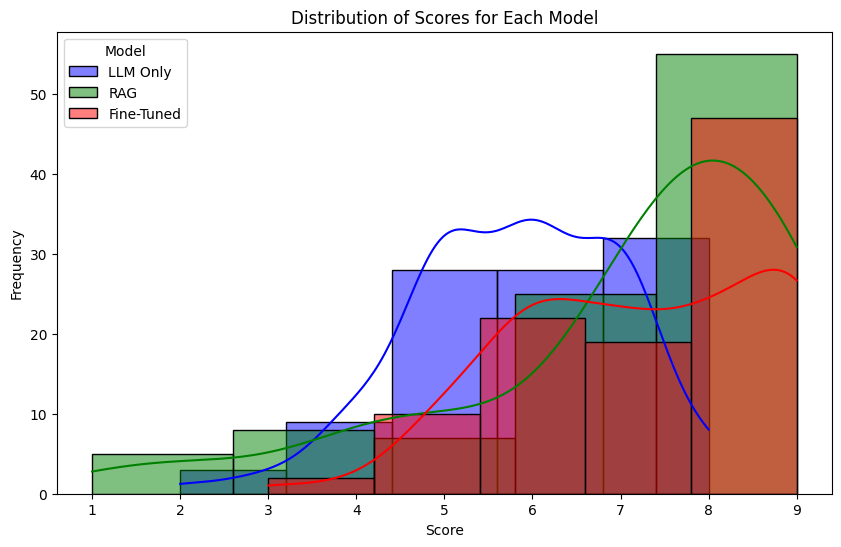

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(results['LLM_Only_Score'], label="LLM Only", kde=True, color='blue', bins=5)
sns.histplot(results['RAG_Score'], label="RAG", kde=True, color='green', bins=5)
sns.histplot(results['Fine_Tuned_Score'], label="Fine-Tuned", kde=True, color='red', bins=5)
plt.legend(title="Model")
plt.title('Distribution of Scores for Each Model')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


In [ ]:
results[['LLM_Only_Score', 'RAG_Score', 'Fine_Tuned_Score']].describe()

,LLM_Only_Score,RAG_Score,Fine_Tuned_Score
count,100.000000,100.000000,100.000000
mean,5.810000,7.060000,7.260000
std,1.195066,1.983874,1.460732
min,2.000000,1.000000,3.000000
25%,5.000000,6.750000,6.000000
50%,6.000000,8.000000,7.000000
75%,7.000000,8.000000,9.000000
max,8.000000,9.000000,9.000000


In [ ]:
average_llm_only_score = results['LLM_Only_Score'].mean()
average_rag_score = results['RAG_Score'].mean()
average_fine_tuned_score = results['Fine_Tuned_Score'].mean()

print("Average LLM Only Score:", average_llm_only_score)
print("Average RAG Score:", average_rag_score)
print("Average Fine-Tuned Score:", average_fine_tuned_score)

Average LLM Only Score: 5.81
Average RAG Score: 7.06
Average Fine-Tuned Score: 7.26
